In [148]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from math import log,exp


- 导入数据   
- 求出（对数）极大似然函数,求出极大似然估计
- 画出极大似然函数图

In [246]:
class ML():
    def __init__(self, data, likelihood):
        self.data = data
        self.likelihood = likelihood
    def lf(self, parameters):
        #计算似然函数
        return self.likelihood(parameters)
    def mlf(self):
        #计算极大似然函数和极大似然估计
        initial = [1.0, 1.0]
        result = minimize(lambda params: - self.likelihood(params), initial, method='L-BFGS-B')
        mle = result.x
        max_likelihood = - result.fun
        return max_likelihood, mle
    def lf_plot(self):
        #做参数网格，算出对应似然值
        l_range = np.linspace(0.1, 2.0, 20)
        g_range = np.linspace(0.1, 2.0, 20)
        L, G = np.meshgrid(l_range, g_range)
        P_mat = np.zeros_like(L)
        for i in range(L.shape[0]):
            for j in range(L.shape[1]):
                P_mat[i][j] =  self.lf([L[i, j], G[i, j]])
        #找到最大值点
        ml_ind = np.unravel_index(P_mat.argmax(), P_mat.shape)
        ml_l = L[ml_ind]
        ml_g = G[ml_ind]
        ml = P_mat[ml_ind]         
        #设定画板
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        #输入数据
        ax.scatter(ml_l, ml_g, ml, color='red', marker='o', label='MLE')
        ax.plot_wireframe(L, G, P_mat)
        
        ax.set_xlabel('lambda')
        ax.set_ylabel('gamma')
        ax.set_zlabel('likelihood')
        plt.show()


导入原始数据

In [202]:
files = ['Complete.xls', 'Left censoring.xls', 'Right censoring.xls',"Interval censoring.xls", "Left trunctation.xls", "Right trunctation.xls"]
cpl, lc, rc, ic, lt, rt = (pd.read_excel(f).to_numpy() for f in files)

由给定的hazard function可推导出：
$$ \lambda(t) = \lambda\gamma(\lambda t)^{\gamma-1}$$
$$S = e^{-(\lambda t)^{\gamma}}$$
$$F(t) = 1 - e^{-(\lambda t)^{\gamma}}$$
$$f(t) = \lambda^{\gamma}\gamma t^{\gamma-1}e^{-(\lambda t)^\gamma}$$


## Case 1:
$$L(\lambda,\gamma) = \prod_i f(t_i)$$
$$L = (\lambda^\gamma\gamma)^n(\prod_i t_i)^{\gamma-1}exp\{-\lambda^\gamma \sum_i t_i^\gamma\}$$
$$l = n\gamma log\lambda + nlog\gamma +(\gamma-1)\sum_i log t_i - \lambda^{\gamma}\sum_i t_i^\gamma$$

调整数据格式

In [203]:
cpldata = cpl.reshape(-1)

定义对数极大似然函数

In [118]:
def cpl_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    n = cpldata.shape[0]
    likelihood = n * g * log(l) + n * log(g) + (g - 1) * np.log(cpldata).sum() - l ** g * (cpldata ** g).sum()
    return likelihood  


In [119]:
cplML = ML(cpl, cpl_likelihood)

计算极大似然函数和估计

In [120]:
ml, est = cplML.mlf()
print(ml)
print(est)

-1000.6486409663372
[0.99595217 1.00568509]


作图

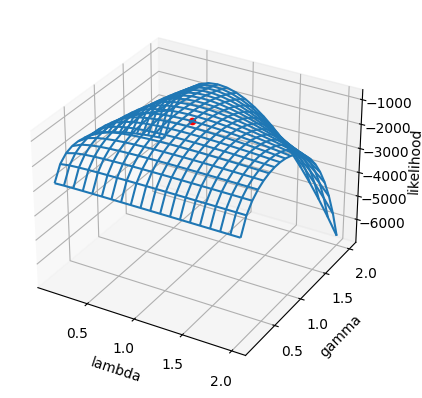

In [121]:
cplML.lf_plot()

## Case 2: Right Censoring
$$L(\lambda, \gamma) = \prod_i\{\lambda^\gamma \gamma t_i^{\gamma-1}exp\{-(\lambda t_i)^\gamma\}\}^{\delta_i}\{exp\{-(\lambda t_i)^\gamma\}\}^{1-\delta_i}$$
$$l(\lambda, \gamma) = \sum_i(\gamma log\lambda + log\gamma)\delta_i + (\gamma - 1)\sum_i\delta_i log t_i - \lambda^\gamma\sum_i t_i^\gamma$$ 

In [146]:
rc_t, rc_d = rc[:,0], rc[:,1]

In [138]:
def rc_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = (g * log(l) + log(g)) * rc_d.sum() + (g - 1) * (rc_d * np.log(rc_t)).sum() - l ** g * (rc_t ** g).sum()
    return likelihood

In [139]:
rcML = ML(rc, rc_likelihood)

In [141]:
rcml, rcmle = rcML.mlf()
print(rcml)
print(rcmle)

-708.2562627646453
[0.99752276 1.00656483]


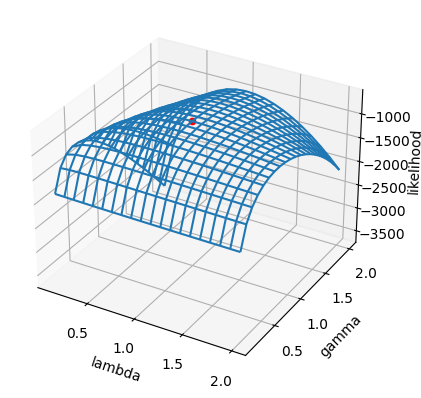

In [142]:
rcML.lf_plot()

## Case 3: Left Censoring
$$L(\lambda, \gamma) = \prod_i\{\lambda^\gamma \gamma t_i^{\gamma-1}exp\{-(\lambda t_i)^\gamma\}\}^{\delta_i}\{1-exp\{-(\lambda t_i)^\gamma\}\}^{1-\delta_i}$$
$$l(\lambda, \gamma) = \sum_i(\gamma log\lambda + log\gamma)\delta_i + (\gamma - 1)\sum_i\delta_i log t_i -[(\lambda t_i)^\gamma - \delta_i] + \sum(1-\delta_i)log\{1-exp[-\lambda^\gamma]exp[-t_i^\gamma]\}$$ 

-[(\lambda * t_i)^\gamma - delta_i]

In [261]:
lc_t, lc_d = lc[:, 0], lc[:, 1]

In [268]:
def lc_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = (np. log((l ** g * g * (lc_t ** (g - 1)) * np.exp(-(l * lc_t) ** g))) * lc_d  +  np.log((1 - np.exp(-(l * lc_t) ** g))) * (1 - lc_d)).sum()
    return likelihood

In [269]:
lcML = ML(lc, lc_likelihood)

In [270]:
lcml, lcest = lcML.mlf()
print(lcml)
print(lcest)

-1259.5022213542377
[0.99580421 1.00602566]


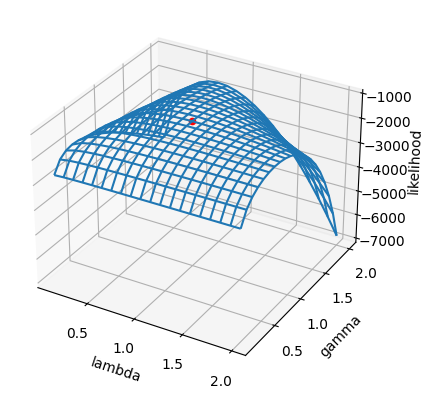

In [271]:
lcML.lf_plot()

## Case 4: Interval Censoring
Let $l_i, u_i$ denote the lower, upper bound.
$$L(\lambda, \gamma) = \prod_i[exp\{-(\lambda l_i)^\gamma\} - exp\{-(\lambda u_i)^\gamma\}]$$
$$ l = \sum_ilog\{exp[-(\lambda l_i)^\gamma] - exp[-(\lambda u_i)^\gamma]\}

In [154]:
ic_l, ic_u = ic[:, 0], ic[:, 1]

In [155]:
def ic_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = np.log(np.exp(- (l * ic_l) ** g) - np.exp(- (l * ic_u) ** g)).sum()
    return likelihood


In [156]:
icML = ML(ic, ic_likelihood)

In [158]:
icml, icest = icML.mlf()
print(icml)
print(icest)

-1042.1853620272493
[0.99164822 1.00933283]


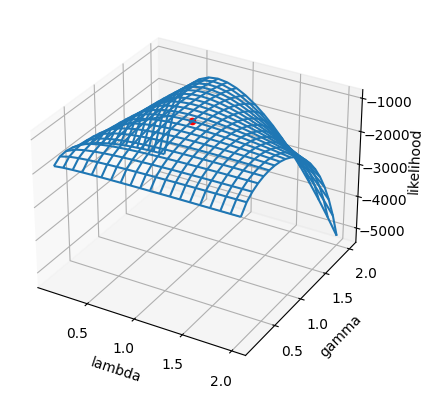

In [159]:
icML.lf_plot()

## Case 5: Left Trunctaion
$$ L_i(\lambda, \gamma) = \frac{\lambda^\gamma \gamma t_i^{\gamma-1} exp[-(\lambda t_i)^\gamma]}{exp[-\lambda u_i]^\gamma}$$
$$l = n(\gamma log\lambda + log\gamma) + (\gamma-1)\sum_i log t_i - \lambda^\gamma \sum_i(t_i^\gamma - u_i^\gamma)$$



In [161]:
lt_time , lt_t = lt[:, 0], lt[:, 1]
lt_n = lt.shape[0]

In [162]:
def lt_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = lt_n * (g * log(l) + log(g)) + (g - 1) * np.log(lt_time).sum() - l ** g * (lt_time ** g - lt_t ** g).sum()
    return likelihood

In [163]:
ltML = ML(lt, lt_likelihood)

In [164]:
ltml, ltest = ltML.mlf()
print(ltml)
print(ltest)

-818.0022217355998
[0.98283882 1.0084967 ]


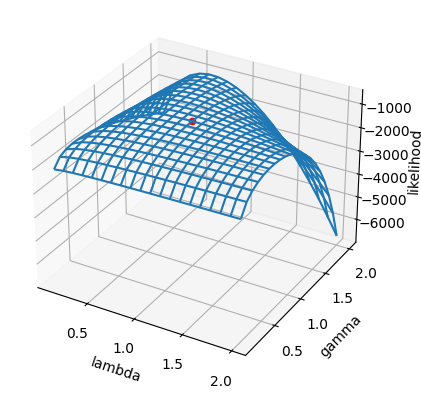

In [165]:
ltML.lf_plot()

## Case 6: Right Trunctation
$$ L_i(\lambda, \gamma) = \frac{\lambda^\gamma \gamma t_i^{\gamma-1} exp[-(\lambda t_i)^\gamma]}{1- exp[-\lambda u_i]^\gamma}$$
$$l = n(\gamma log\lambda + log\gamma) + (\gamma-1)\sum_i log t_i - \sum_i log\{1-exp[-(\lambda u_i)^\gamma]\}$$


In [187]:
rt_time, rt_t = rt[:, 0], rt[:, 1]
rt_n = rt.shape[0]


In [188]:
def rt_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = rt_n * (g * log(l) + log(g)) + (g - 1.0) * np.log(rt_time).sum() - l ** g * (rt_time ** g).sum() - np.log(1.0 - np.exp(-(l * rt_t)**g)).sum()
    return likelihood

In [189]:
rtML = ML(rt, rt_likelihood)

In [190]:
rtml, rtest = rtML.mlf()
print(rtml)
print(rtest)

-116.01156213508335
[1.07550199 1.01479618]


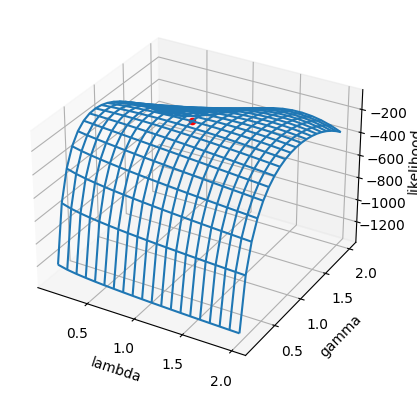

In [191]:
rtML.lf_plot()

## Case 7: Right Censoring ignored
$$L(\lambda, \gamma) = \prod_i \{\lambda^\gamma \gamma t_i^{\gamma-1}exp[-(\lambda t_i)^\gamma]\}^{\delta_i}$$
$$l = \sum_i \delta_i(log(\lambda^\gamma\gamma) + log t_i^{\gamma-1} - \lambda^\gamma t_i^\gamma)$$


In [192]:
def rci_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = (rc_d * (log(l ** g * g) + np.log(rc_t ** (g - 1)) - l ** g * rc_t ** g)).sum()
    return likelihood

In [193]:
rciML = ML(rc, rci_likelihood)

In [194]:
rciml, rciest = rciML.mlf()
print(rciml)
print(rciest)

-185.73352016106406
[1.86103417 1.29328697]


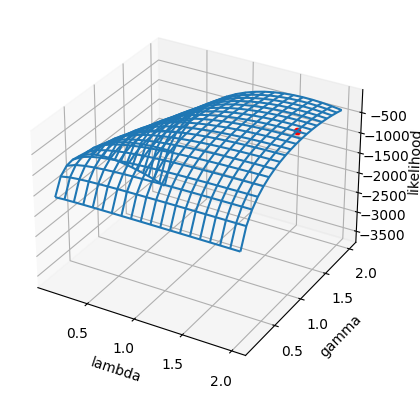

In [195]:
rciML.lf_plot()

## Case 8:Left Censoring ignored
$$L(\lambda, \gamma) = \prod_i \{\lambda^\gamma \gamma t_i^{\gamma-1}exp[-(\lambda t_i)^\gamma]\}^{\delta_i}$$
$$l = \sum_i \delta_i(log(\lambda^\gamma\gamma) + log t_i^{\gamma-1} - \lambda^\gamma t_i^\gamma)$$


In [247]:
def lci_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    likelihood = (lc_d * (log(l ** g * g) + np.log(lc_t ** (g - 1)) - l ** g * lc_t ** g)).sum()
    return likelihood

In [248]:
lciML = ML(lc, lci_likelihood)

In [249]:
lciml, lciest = lciML.mlf()
print(lciml)
print(lciest)

-902.4762941180471
[0.74547575 1.32185532]


## Case 9: Left Trunctation ignored
$$L(\lambda,\gamma) = \prod_i f(t_i)$$
$$L = (\lambda^\gamma\gamma)^n(\prod_i t_i)^{\gamma-1}exp\{-\lambda^\gamma \sum_i t_i^\gamma\}$$
$$l = n\gamma log\lambda + nlog\gamma +(\gamma-1)\sum_i log t_i - \lambda^{\gamma}\sum_i t_i^\gamma$$


In [281]:
def lti_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    n = lt.shape[0]
    likelihood = n * g * log(l) + n * log(g) + (g - 1) * np.log(lt_time).sum() - l ** g * (lt_time ** g).sum()
    return likelihood  

In [282]:
ltiML = ML(lt, lti_likelihood)

In [283]:
ltiml, ltiest = ltiML.mlf()
print(ltiml)
print(ltiest)

-932.3729916342141
[0.74213607 1.31494314]


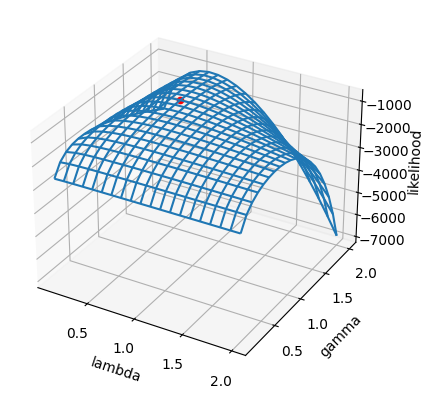

In [284]:
ltiML.lf_plot()

## Case 10: Right Trunctation ignored
$$L(\lambda,\gamma) = \prod_i f(t_i)$$
$$L = (\lambda^\gamma\gamma)^n(\prod_i t_i)^{\gamma-1}exp\{-\lambda^\gamma \sum_i t_i^\gamma\}$$
$$l = n\gamma log\lambda + nlog\gamma +(\gamma-1)\sum_i log t_i - \lambda^{\gamma}\sum_i t_i^\gamma$$


In [272]:
def rti_likelihood(parameters):
    l, g = parameters[0], parameters[1]
    n = rt.shape[0]
    likelihood = n * g * log(l) + n * log(g) + (g - 1) * np.log(rt_time).sum() - l ** g * (rt_time ** g).sum()
    return likelihood  

In [273]:
rtiML = ML(rt, rti_likelihood)
rtiml, rtiest = rtiML.mlf()
print(rtiml)
print(rtiest)

-186.08872137133847
[1.87325907 1.29321855]


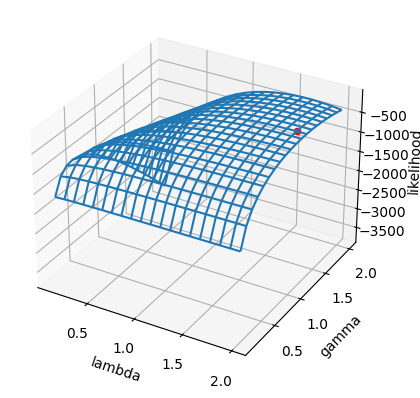

In [274]:
rtiML.lf_plot()